In [159]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import aux_functions as aux

In [161]:
def network(x):
    # Input Layer
    input_layer = tf.reshape(train_data, [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters = 5,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training = True)#mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    
    return logits, conv1

In [162]:
def compute_cross_entropy(logits, y):
    y_pred = tf.nn.softmax(logits, name='y_pred') # the predicted probability for each example.

    # Compute the average cross-entropy across all the examples.
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), axis=[1]))
    return cross_entropy

def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

In [163]:
def deconvolute(layer):
    unConv1 = tf.layers.conv2d_transpose( 
        inputs = layer, 
        filters = 5, 
        kernel_size=[5, 5], 
        padding = "SAME")
    
    return unConv1

In [145]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images[:50,] # Returns np.array
train_labels = np.asarray(mnist.train.labels[:50], dtype=np.int32)
eval_data = mnist.test.images[:10,] # Returns np.array
eval_labels = np.asarray(mnist.test.labels[:10], dtype=np.int32)

print("")
print("MNIST Data Dimensions")
print("train_data")
print(train_data.shape)
print("train_labels")
print(train_labels.shape)
print("eval")
print(eval_data.shape)
print("eval_labels")
print(eval_labels.shape)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz

MNIST Data Dimensions
train_data
(50, 784)
train_labels
(50,)
eval
(10, 784)
eval_labels
(10,)


In [166]:
##
## Train CNN
##

with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 784], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    
    logits, conv1 = network(x)
    loss = compute_cross_entropy(logits = logits, y = y)
    accuracy = compute_accuracy(logits, y)
    
    onehot_train_labels = tf.one_hot(indices = tf.cast(train_labels, tf.int32), depth = 10)
    onehot_eval_labels = tf.one_hot(indices = tf.cast(eval_labels, tf.int32), depth = 10)
    
    opt = tf.train.AdamOptimizer(0.01)
    train_step = opt.minimize(loss)
    
    #Deconvolute
    unConv1 = deconvolute(conv1)
    
    # Let's put the summaries below
    
    # create summary for loss and accuracy
    tf.summary.scalar('loss', loss) 
    tf.summary.scalar('accuracy', accuracy)
    
    # create summary for logits
    tf.summary.histogram('logits', logits)
    
    # create summary for input image
    tf.summary.image('input', tf.reshape(x, [-1, 28, 28, 1]))
    
    summary_op = tf.summary.merge_all()
    
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter('logs/example1', sess.graph)
        
        sess.run(tf.global_variables_initializer())

        lab_train = sess.run(onehot_train_labels)
        lab_eval = sess.run(onehot_eval_labels)
        
        for i in range(31):
            _, ac, summary = sess.run((train_step, accuracy, summary_op),
                                      feed_dict={x: train_data, y: lab_train})
            
            # write the summary output to file
            summary_writer.add_summary(summary, i)

            if i % 10 == 0:
                print('Step {0}: accuracy is {1}'.format(i + 1, ac))
    
        w = sess.run(unConv1)
        #ac = sess.run(accuracy, feed_dict={x: eval_data, y: lab_eval})
        #print('Accuracy on test set: {0}'.format(ac))

Step 1: accuracy is 0.14000000059604645
Step 11: accuracy is 0.8600000143051147
Step 21: accuracy is 1.0
Step 31: accuracy is 1.0


(50, 28, 28, 5)
[-0.08825822 -0.4269197  -1.35903203 -1.77436566 -2.30783534 -0.71149409
  0.50112885  0.27033526 -1.24596632 -1.73115003 -1.07828832 -0.24270964
  0.48722535 -0.71931022 -1.78372979 -1.22266042 -0.56201893  0.27340263
 -0.92770219  0.16941603  1.39464986  1.15155005  0.55716205  0.54184353
  0.41318133  0.03183563  0.          0.        ]


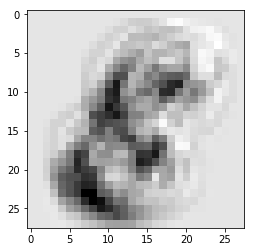

In [171]:
print(w.shape)
print(sum(w[1,:,:,1]))

plt.imshow(np.array(w[5,:,:,2]), cmap='gray')
plt.show()